In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# load data
dataset = pd.read_csv('./pollution.csv', index_col=0)
dataset

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


# EDA

In [2]:
values = dataset.values
values

array([[129.0, -16, -4.0, ..., 1.79, 0, 0],
       [148.0, -15, -4.0, ..., 2.68, 0, 0],
       [159.0, -11, -5.0, ..., 3.57, 0, 0],
       ...,
       [10.0, -22, -3.0, ..., 242.7, 0, 0],
       [8.0, -22, -4.0, ..., 246.72, 0, 0],
       [12.0, -21, -3.0, ..., 249.85, 0, 0]], dtype=object)

In [3]:
# 43800 samples, 8 features (exclude time)
values.shape

(43800, 8)

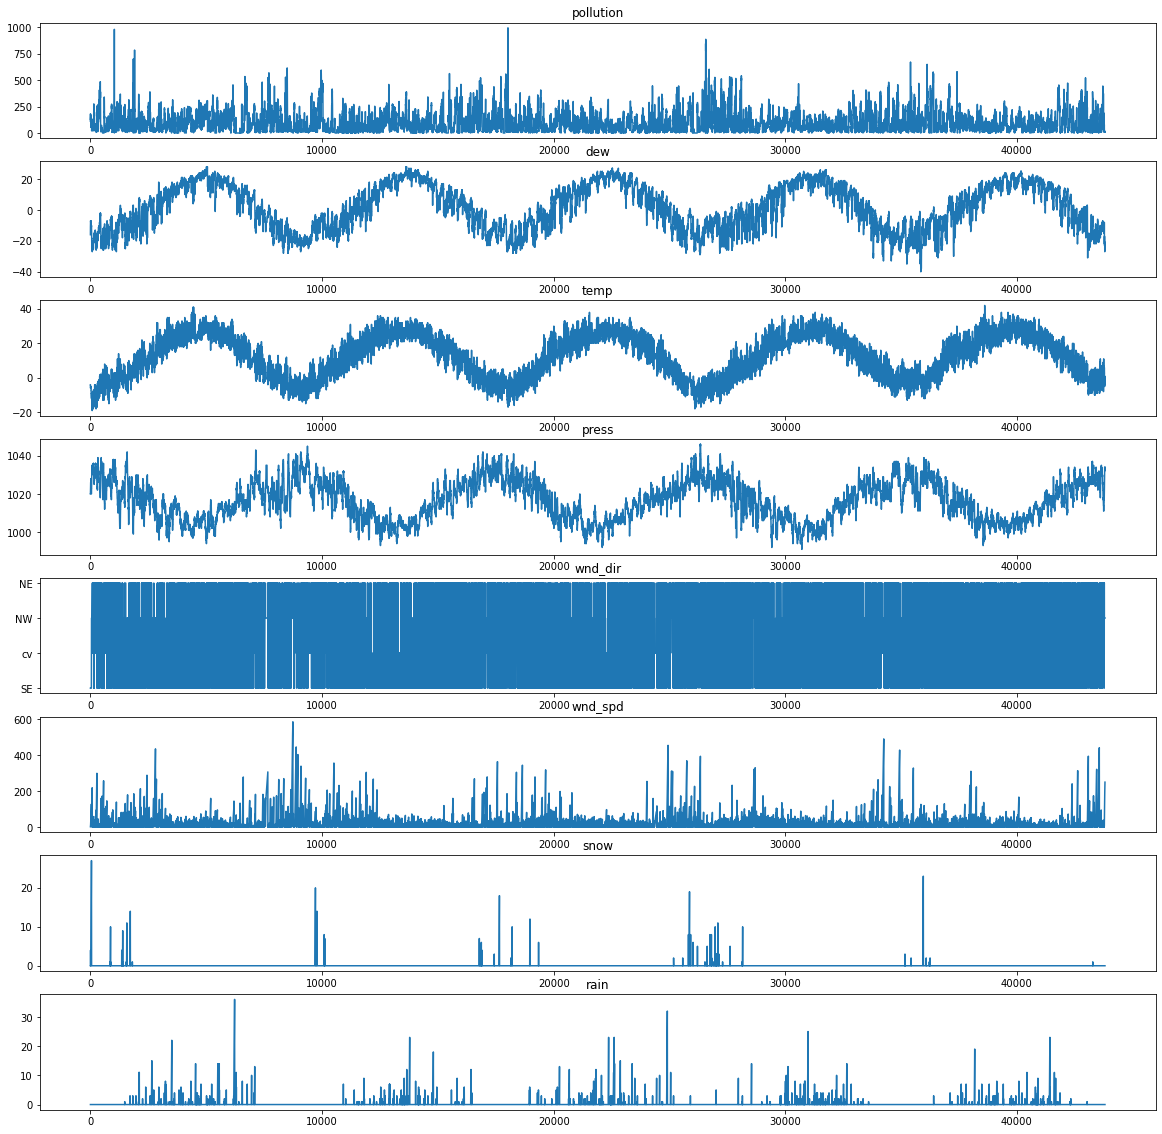

In [4]:
import matplotlib.pyplot as plt

i = 1
plt.figure(figsize = (20,20))
groups = [0,1,2,3,4,5,6,7]
for group in groups:
    plt.subplot(8,1,i)
    plt.plot(values[:,group])
    plt.title(dataset.columns[group])
    i = i + 1
plt.show()

# Feature engineering

* label encoding

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
values[:, 4] = le.fit_transform(values[:,4])
values[:, 4]

array([2, 2, 2, ..., 1, 1, 1], dtype=object)

* 0-1 data standization

In [6]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
scaled = mm.fit_transform(values)
scaled

array([[0.12977867, 0.35294118, 0.24590164, ..., 0.00229001, 0.        ,
        0.        ],
       [0.14889336, 0.36764706, 0.24590164, ..., 0.00381099, 0.        ,
        0.        ],
       [0.15995976, 0.42647059, 0.2295082 , ..., 0.00533197, 0.        ,
        0.        ],
       ...,
       [0.01006036, 0.26470588, 0.26229508, ..., 0.41399641, 0.        ,
        0.        ],
       [0.00804829, 0.26470588, 0.24590164, ..., 0.42086644, 0.        ,
        0.        ],
       [0.01207243, 0.27941176, 0.26229508, ..., 0.4262155 , 0.        ,
        0.        ]])

* transmit the time-series data ===> supervised learning data

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # predict sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # concat
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop nan values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
reframed = series_to_supervised(scaled, 1, 1)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545455,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545455,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563636,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563636,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563636,0.666667,0.009912,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563636,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563636,0.666667,0.011433,0.111111,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,0.010060,0.264706,0.278689,0.763636,0.333333,0.385730,0.000000,0.0,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0
43798,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0,0.008048,0.264706,0.245902,0.781818,0.333333,0.420866,0.000000,0.0


In [9]:
# t-1 8features ===> t pollution
values = reframed.iloc[:, :9]
values

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545455,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563636,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563636,0.666667,0.009912,0.074074,0.0,0.109658
...,...,...,...,...,...,...,...,...,...
43795,0.010060,0.264706,0.278689,0.763636,0.333333,0.385730,0.000000,0.0,0.008048
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.010060
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0,0.010060
43798,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0,0.008048


# Dataset splitting

In [10]:
n_train = int(len(values)*0.8)
n_train

35039

In [11]:
# dataset split 80% 20%
train = values.loc[:n_train, :]
test = values.loc[n_train:, :]
train

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545455,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563636,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563636,0.666667,0.009912,0.074074,0.0,0.109658
...,...,...,...,...,...,...,...,...,...
35035,0.015091,0.308824,0.442623,0.400000,0.333333,0.187132,0.000000,0.0,0.022133
35036,0.022133,0.308824,0.426230,0.400000,0.333333,0.195540,0.000000,0.0,0.018109
35037,0.018109,0.279412,0.426230,0.418182,0.333333,0.203948,0.000000,0.0,0.023139
35038,0.023139,0.279412,0.426230,0.418182,0.333333,0.213877,0.000000,0.0,0.020121


In [12]:
test

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
35039,0.020121,0.279412,0.409836,0.418182,0.333333,0.222285,0.0,0.0,0.023139
35040,0.023139,0.294118,0.426230,0.418182,0.333333,0.234504,0.0,0.0,0.024145
35041,0.024145,0.294118,0.426230,0.418182,0.333333,0.244433,0.0,0.0,0.053320
35042,0.053320,0.294118,0.426230,0.400000,0.333333,0.251303,0.0,0.0,0.065392
35043,0.065392,0.294118,0.409836,0.400000,0.333333,0.258173,0.0,0.0,0.070423
...,...,...,...,...,...,...,...,...,...
43795,0.010060,0.264706,0.278689,0.763636,0.333333,0.385730,0.0,0.0,0.008048
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.0,0.0,0.010060
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.0,0.0,0.010060
43798,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.0,0.0,0.008048


In [13]:
# -1 : the last col(y), :-1 all the cols except the (y)
train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1]
test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]
test_X

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1)
35039,0.020121,0.279412,0.409836,0.418182,0.333333,0.222285,0.0,0.0
35040,0.023139,0.294118,0.426230,0.418182,0.333333,0.234504,0.0,0.0
35041,0.024145,0.294118,0.426230,0.418182,0.333333,0.244433,0.0,0.0
35042,0.053320,0.294118,0.426230,0.400000,0.333333,0.251303,0.0,0.0
35043,0.065392,0.294118,0.409836,0.400000,0.333333,0.258173,0.0,0.0
...,...,...,...,...,...,...,...,...
43795,0.010060,0.264706,0.278689,0.763636,0.333333,0.385730,0.0,0.0
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.0,0.0
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.0,0.0
43798,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.0,0.0


In [14]:
test_y

35039    0.023139
35040    0.024145
35041    0.053320
35042    0.065392
35043    0.070423
           ...   
43795    0.008048
43796    0.010060
43797    0.010060
43798    0.008048
43799    0.012072
Name: var1(t), Length: 8761, dtype: float64

* transmit to 3D format for LSTM training: [sample_number, time_steps, feature_nums] 

In [15]:
# transmit to 3D format for LSTM training: [sample_number, time_steps, feature_nums] 
train_X = train_X.values.reshape((train_X.shape[0], 1, 8))
test_X = test_X.values.reshape((test_X.shape[0], 1, 8))

In [16]:
train_X

array([[[0.12977867, 0.35294118, 0.24590164, ..., 0.00229001,
         0.        , 0.        ]],

       [[0.14889336, 0.36764706, 0.24590164, ..., 0.00381099,
         0.        , 0.        ]],

       [[0.15995976, 0.42647059, 0.2295082 , ..., 0.00533197,
         0.        , 0.        ]],

       ...,

       [[0.01810865, 0.27941176, 0.42622951, ..., 0.20394771,
         0.        , 0.        ]],

       [[0.02313883, 0.27941176, 0.42622951, ..., 0.21387678,
         0.        , 0.        ]],

       [[0.02012072, 0.27941176, 0.40983607, ..., 0.22228488,
         0.        , 0.        ]]])

# LSTM Model training

In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


# lstm model setting
model = Sequential()
# add LSTM layer, neuron numbers:50 (features)
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
# full connection NN => pm2.5 values
model.add(Dense(1))

# optimizer and loss function
model.compile(loss='mse', optimizer = 'adam')

# model training
result = model.fit(train_X, train_y, epochs=10, batch_size=1024, validation_data = (test_X, test_y), verbose=1, shuffle=True)
result

Epoch 1/10
35/35 [==============================] - 6s 52ms/step - loss: 0.0103 - val_loss: 0.0073
Epoch 2/10
35/35 [==============================] - 0s 8ms/step - loss: 0.0065 - val_loss: 0.0060
Epoch 3/10
35/35 [==============================] - 0s 8ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 4/10
35/35 [==============================] - 0s 7ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 5/10
35/35 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 6/10
35/35 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 7/10
35/35 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 8.0745e-04
Epoch 8/10
35/35 [==============================] - 0s 7ms/step - loss: 8.9075e-04 - val_loss: 6.8736e-04
Epoch 9/10
35/35 [==============================] - 0s 7ms/step - loss: 8.2990e-04 - val_loss: 6.4942e-04
Epoch 10/10
35/35 [==============================] - 0s 6ms/step - loss: 8.1238e-04 - val_loss: 6

In [18]:
# model predict
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

274/274 [==============================] - 0s 1ms/step


In [19]:
train_predict

array([[0.13184473],
       [0.14930329],
       [0.16302092],
       ...,
       [0.02040444],
       [0.02446532],
       [0.02317939]], dtype=float32)

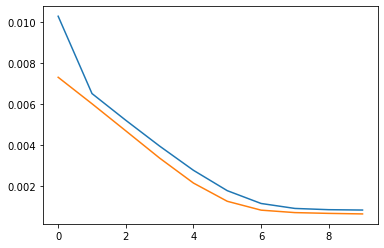

In [20]:
# plot loss (train and test datasets)
plt.plot(result.history['loss'], label='Train')
plt.plot(result.history['val_loss'], label='Test')
plt.show()

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11800     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________


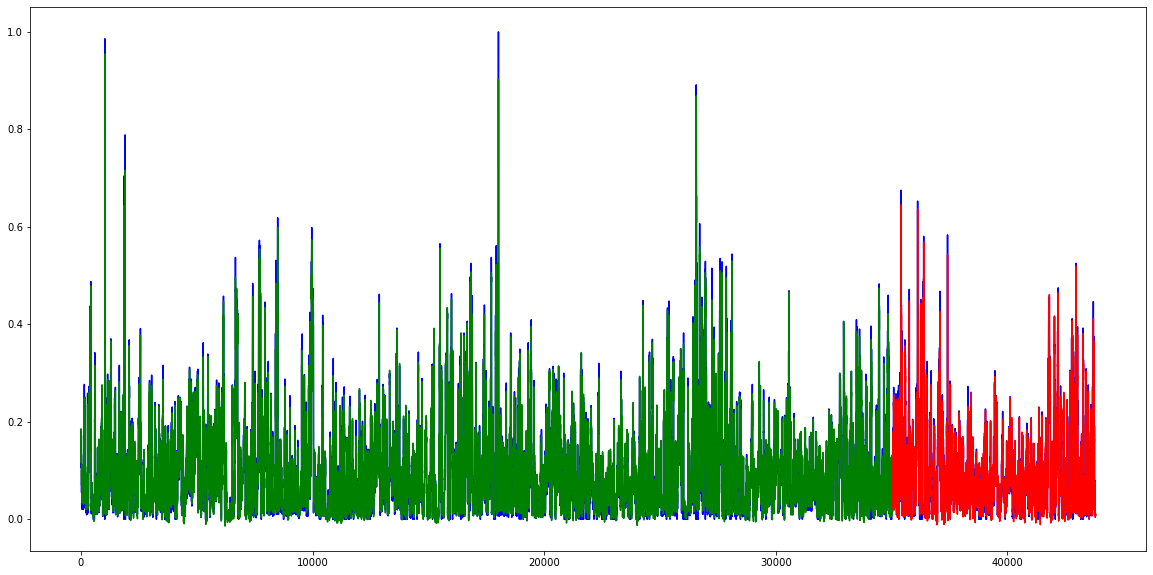

In [22]:
# raw_data: blue
plt.figure(figsize = (20,10))
plt.plot(values.iloc[:,-1], c='b')

# predict_data train: green
plt.plot(train_predict, c='g')

# predict_data test: red
plt.plot([None for _ in train_predict] + [x for x in test_predict], c='r')